# graphical_models_causal_tests

## Global Setup

In [ ]:
!git clone https://github.com/leonardoLavagna/Intelligent-Control-of-Microfluidic-Systems/

In [ ]:
import os
os.chdir("Intelligent-Control-of-Microfluidic-Systems")
!pip install -r requirements.txt

## Dataset

In [3]:
import pandas as pd

df = pd.read_csv("Data/data_1.csv")
#df.head()

## Build candidate 3-nodes causal graphs

### Setup

In [4]:
import itertools
import numpy as np
import pandas as pd

In [5]:
import networkx as nx
import matplotlib.pyplot as plt
import math
from math import log

### Data

In [6]:
disc_df = pd.DataFrame()
for col in df.columns:
    if pd.api.types.is_numeric_dtype(df[col]):
        disc_df[col] = pd.qcut(df[col], q=3, duplicates="drop").astype(str)
    else:
        disc_df[col] = df[col].astype(str)

### Auxiliaries

In [7]:
def all_dags(nodes):
    """
    Generate a small set of candidate DAG structures for 3 nodes.
    Each DAG is represented as a list of directed edges (tuples).

    Args:
      - nodes (tuple of str): The three node names (A, B, C).

    Returns:
      - list[list[tuple]]: Each element is a DAG represented as a
        list of (parent, child) edges.
    """
    A, B, C = nodes
    return [
        [(A, B), (A, C)],       # fork: A -> B, A -> C
        [(B, A), (C, A)],       # collider: B -> A <- C
        [(A, B), (B, C)],       # chain: A -> B -> C
        [(A, C), (C, B)],       # reverse chain: A -> C -> B
        [(B, C), (C, A)],       # another chain: B -> C -> A
    ]


In [8]:
def get_cpt(data, child, parents):
    """
    Estimate the conditional probability table (CPT) for a given child node
    conditioned on its parent nodes.

    Args:
      - data (pd.DataFrame): The dataset containing all variables.
      - child (str): The name of the child variable for which the CPT is estimated.
      - parents (list of str): The names of parent variables.

    Returns:
      - dict: A nested dictionary of the form:
          { parent_state: { child_state: probability } }
        where:
          - parent_state is a tuple of parent values (or None if no parents).
          - child_state is a possible value of the child variable.
          - probability is the estimated conditional probability P(child | parents).
    """
    if not parents:
        counts = data[child].value_counts(normalize=True)
        return {None: counts.to_dict()}
    # Count joint occurrences of parents + child
    counts = (
        data.groupby(parents + [child], observed=True)
        .size()
        .reset_index(name="count")
    )
    # Count total occurrences of parent configurations
    parent_counts = (
        data.groupby(parents, observed=True)
        .size()
        .reset_index(name="total")
    )
    # Merge to compute conditional probabilities
    merged = pd.merge(counts, parent_counts, on=parents)
    merged["prob"] = merged["count"] / merged["total"]
    # Build dictionary CPT
    cpt = {}
    for _, row in merged.iterrows():
        key = tuple(row[p] for p in parents)
        if key not in cpt:
            cpt[key] = {}
        cpt[key][row[child]] = row["prob"]
    return cpt

In [9]:
def log_likelihood(data, dag):
    """
    Compute the log-likelihood of the data given a candidate DAG structure.

    Args:
      - data (pd.DataFrame): The dataset containing all variables.
      - dag (list of tuples): Directed edges representing the DAG structure.
        Example: [('A', 'B'), ('C', 'B')] means A -> B, C -> B.

    Returns:
      - float: The total log-likelihood of the data under the given DAG model.
    """
    # Estimate CPTs for each node given its parents
    cpts = {}
    nodes = set(itertools.chain(*dag))
    for node in nodes:
        parents = [u for (u, v) in dag if v == node]
        cpts[node] = get_cpt(data, node, parents)
    # Accumulate log-likelihood across all rows
    ll = 0.0
    for _, row in data.iterrows():
        p = 1.0
        for node in nodes:
            parents = [u for (u, v) in dag if v == node]
            # marginal probability
            if not parents:
                prob = cpts[node][None].get(row[node], 1e-6)
            # conditional probability
            else:
                key = tuple(row[p] for p in parents)
                prob = cpts[node].get(key, {}).get(row[node], 1e-6)
            p *= prob
        # add log probability (with small epsilon for stability)
        ll += log(p + 1e-12)
    return ll

In [10]:
def num_params(data, dag):
    """
    Compute the number of free parameters required for a DAG model.

    Args:
      - data (pd.DataFrame): The dataset containing all variables.
      - dag (list of tuples): Directed edges representing the DAG structure.
        Example: [('A', 'B'), ('C', 'B')] means A -> B, C -> B.

    Returns:
      - int: The total number of free parameters in the DAG.
    """
    params = 0
    nodes = set(itertools.chain(*dag))
    for node in nodes:
        parents = [u for (u, v) in dag if v == node]
        states_child = data[node].nunique()
        if not parents:
            # If no parents: need (states - 1) parameters for multinomial distribution
            params += states_child - 1
        else:
            # If parents exist: parameters grow with product of parent state counts
            parent_states = np.prod([data[p].nunique() for p in parents])
            params += parent_states * (states_child - 1)
    return params

In [11]:
def score_dag(data, dag):
    """
    Compute log-likelihood, AIC, and BIC scores for a given DAG.

    Args:
      - data (pd.DataFrame): The dataset containing all variables.
      - dag (list of tuples): Directed edges representing the DAG structure.
        Example: [('A', 'B'), ('C', 'B')] means A -> B, C -> B.

    Returns:
      - tuple: (ll, aic, bic)
        * ll (float): Log-likelihood of the DAG given the data.
        * aic (float): Akaike Information Criterion, penalizes number of parameters (2 * k).
        * bic (float): Bayesian Information Criterion, penalizes number of parameters with sample size (log(n) * k).
    """
    ll = log_likelihood(data, dag)
    k = num_params(data, dag)
    n = len(data)
    aic = 2 * k - 2 * ll
    bic = log(n) * k - 2 * ll
    return ll, aic, bic


In [12]:
def plot_dag(row, ax=None):
    """
    Plot a DAG from a row in the results dataframe.

    Args:
      - row (pd.Series): A row from res_df containing keys 'nodes' and 'dag'.
      - ax (matplotlib.axes.Axes, optional): Axis to plot on. Creates new if None.

    Returns:
      - ax: The matplotlib axis with the DAG plot.
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(4, 3))

    G = nx.DiGraph()
    G.add_edges_from(row['dag'])
    pos = nx.spring_layout(G, seed=42)
    nx.draw(
        G, pos, with_labels=True, arrows=True,
        node_color="skyblue", node_size=2000,
        font_size=10, font_weight="bold",
        arrowstyle="->", arrowsize=15, ax=ax
    )
    ax.set_title(f"Nodes={row['nodes']}\nBIC={row['BIC']:.1f}, AIC={row['AIC']:.1f}", fontsize=10)
    return ax

In [13]:
def plot_top_dags(res_df, top_n=9):
    """
    Plot the top N DAGs from the results dataframe.

    Args:
      - res_df (pd.DataFrame): DataFrame with DAG results (must contain 'dag', 'nodes', 'BIC', 'AIC').
      - top_n (int): Number of DAGs to plot.
    """
    n = min(top_n, len(res_df))
    ncols = 3
    nrows = math.ceil(n / ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 4*nrows))
    axes = axes.flatten()
    for i in range(n):
        plot_dag(res_df.iloc[i], ax=axes[i])
    # Remove unused axes if top_n < nrows*ncols
    for j in range(n, len(axes)):
        fig.delaxes(axes[j])
    plt.tight_layout()
    plt.show()

### Results

In [14]:
results = []

for triplet in itertools.combinations(disc_df.columns, 3):
    sub_df = disc_df[list(triplet)]
    print(f"Processing triplet {triplet}, rows={len(sub_df)}, uniques={[sub_df[c].nunique() for c in triplet]}")
    dags = all_dags(triplet)
    for i, dag in enumerate(dags, 1):
        try:
            ll, aic, bic = score_dag(sub_df, dag)
            results.append({
                "nodes": triplet,
                "dag": dag,
                "LL": ll,
                "AIC": aic,
                "BIC": bic
            })
        except Exception as e:
            print(f"  Graph {i} failed: {e}")


res_df = pd.DataFrame(results)
res_df = res_df.sort_values("BIC").reset_index(drop=True)
print("\nTop candidate DAGs (by BIC score):")
for i, row in res_df.head(10).iterrows():
    print(f"Rank {i+1}: Nodes={row['nodes']}, BIC={row['BIC']:.2f}, AIC={row['AIC']:.2f}, LL={row['LL']:.2f}, Edges={row['dag']}")
res_df.to_csv("candidate_dags_results.csv", index=False)
print("Results saved to candidate_dags_results.csv")

Processing triplet ('ESM', 'HSPC', 'CHOL'), rows=303, uniques=[2, 2, 3]
Processing triplet ('ESM', 'HSPC', 'PEG'), rows=303, uniques=[2, 2, 2]
Processing triplet ('ESM', 'HSPC', 'TFR'), rows=303, uniques=[2, 2, 3]
Processing triplet ('ESM', 'HSPC', 'FRR'), rows=303, uniques=[2, 2, 3]
Processing triplet ('ESM', 'HSPC', 'AQUEOUS'), rows=303, uniques=[2, 2, 2]
Processing triplet ('ESM', 'HSPC', 'SIZE'), rows=303, uniques=[2, 2, 3]
Processing triplet ('ESM', 'HSPC', 'PDI'), rows=303, uniques=[2, 2, 3]
Processing triplet ('ESM', 'CHOL', 'PEG'), rows=303, uniques=[2, 3, 2]
Processing triplet ('ESM', 'CHOL', 'TFR'), rows=303, uniques=[2, 3, 3]
Processing triplet ('ESM', 'CHOL', 'FRR'), rows=303, uniques=[2, 3, 3]
Processing triplet ('ESM', 'CHOL', 'AQUEOUS'), rows=303, uniques=[2, 3, 2]
Processing triplet ('ESM', 'CHOL', 'SIZE'), rows=303, uniques=[2, 3, 3]
Processing triplet ('ESM', 'CHOL', 'PDI'), rows=303, uniques=[2, 3, 3]
Processing triplet ('ESM', 'PEG', 'TFR'), rows=303, uniques=[2, 2,

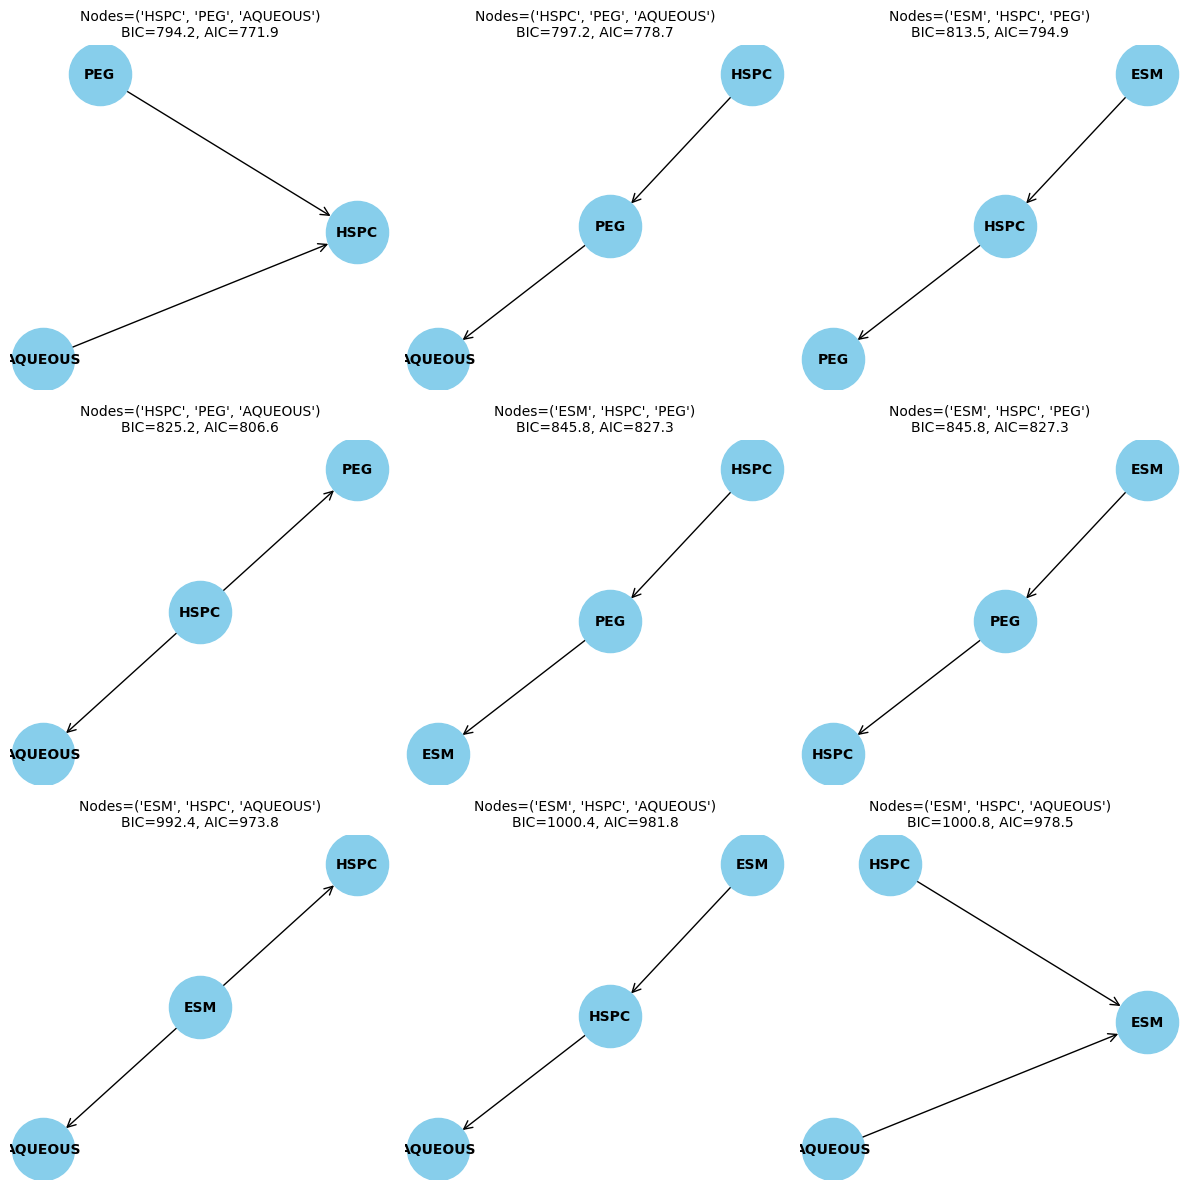

In [15]:
plot_top_dags(res_df, top_n=9)

## Expanded candidate DAGs

In [ ]:
!pip install pgmpy

In [17]:
from pgmpy.estimators.CITests import chi_square

### Constaint-based combinations (triplets motifs plus independence)

In [18]:
def is_independent(X, Y, Z, data, alpha=0.05):
    """
    Wrapper around pgmpy's chi_square test for conditional independence.

    Args:
      - X (str): First variable.
      - Y (str): Second variable.
      - Z (list of str): Conditioning set (can be empty).
      - data (pd.DataFrame): Dataset.
      - alpha (float): Significance level.

    Returns:
      - bool: True if X ⫫ Y | Z (independent), False otherwise.
    """
    _, pval, _ = chi_square(X, Y, Z, data, boolean=False)
    return pval >= alpha


In [19]:
def expand_dag(data, dag_edges, variables, alpha=0.05):
    """
    Expand a seed DAG by testing edges with conditional independence.

    Args:
      - data (pd.DataFrame): Discretized dataset.
      - dag_edges (list of tuples): Seed DAG edges [(A, B), ...].
      - variables (list of str): All variables to consider.
      - alpha (float): Significance threshold.

    Returns:
      - list of tuples: Expanded set of edges.
    """
    dag = nx.DiGraph()
    dag.add_edges_from(dag_edges)
    present_nodes = set(dag.nodes())
    remaining_nodes = set(variables) - present_nodes
    for new_var in remaining_nodes:
        for node in present_nodes:
            # unconditional test for now (Z = [])
            if not is_independent(node, new_var, [], data, alpha):
                dag.add_edge(node, new_var)
                if not nx.is_directed_acyclic_graph(dag):
                    dag.remove_edge(node, new_var)
                    dag.add_edge(new_var, node)
                if not nx.is_directed_acyclic_graph(dag):
                    dag.remove_edge(new_var, node)
        present_nodes.add(new_var)
    return list(dag.edges())

In [20]:
def plot_dag_from_edges(edges, title="", ax=None):
    """
    Plot a DAG given its edges.

    Args:
      - edges (list of tuples): List of directed edges [(u, v), ...].
      - title (str): Plot title.
      - ax (matplotlib.axes.Axes, optional): Axis to plot on.
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(4, 3))

    G = nx.DiGraph()
    G.add_edges_from(edges)
    pos = nx.spring_layout(G, seed=42)
    nx.draw(
        G, pos, with_labels=True, arrows=True,
        node_color="lightblue", node_size=2000,
        font_size=10, font_weight="bold",
        arrowstyle="->", arrowsize=15, ax=ax
    )
    ax.set_title(title, fontsize=10)
    return ax


def plot_expanded_dags(expanded_results, top_n=6):
    """
    Plot the top N expanded DAGs in a grid.

    Args:
      - expanded_results (list of dicts): Output from expansion loop.
      - top_n (int): Number of DAGs to plot.
    """
    n = min(top_n, len(expanded_results))
    ncols = 3
    nrows = math.ceil(n / ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 4*nrows))
    axes = axes.flatten()
    for i in range(n):
        row = expanded_results[i]
        title = f"Seed={row['seed_nodes']}\nExpanded edges={len(row['expanded_edges'])}"
        plot_dag_from_edges(row["expanded_edges"], title, ax=axes[i])
    for j in range(n, len(axes)):
        fig.delaxes(axes[j])
    plt.tight_layout()
    plt.show()

In [21]:
top_dags = res_df.head(3)
expanded_results = []
for idx, row in top_dags.iterrows():
    print(f"\nExpanding DAG {idx+1}: Nodes={row['nodes']}, Edges={row['dag']}")
    expanded = expand_dag(disc_df, row['dag'], list(disc_df.columns), alpha=0.05)
    expanded_results.append({
        "seed_nodes": row['nodes'],
        "seed_edges": row['dag'],
        "expanded_edges": expanded
    })
    print(f"Expanded DAG edges: {expanded}")


Expanding DAG 1: Nodes=('HSPC', 'PEG', 'AQUEOUS'), Edges=[('PEG', 'HSPC'), ('AQUEOUS', 'HSPC')]
Expanded DAG edges: [('PEG', 'HSPC'), ('PEG', 'FRR'), ('PEG', 'ESM'), ('PEG', 'SIZE'), ('PEG', 'TFR'), ('PEG', 'PDI'), ('PEG', 'CHOL'), ('HSPC', 'FRR'), ('HSPC', 'ESM'), ('HSPC', 'SIZE'), ('HSPC', 'TFR'), ('HSPC', 'PDI'), ('HSPC', 'CHOL'), ('AQUEOUS', 'HSPC'), ('AQUEOUS', 'FRR'), ('AQUEOUS', 'ESM'), ('AQUEOUS', 'SIZE'), ('AQUEOUS', 'TFR'), ('AQUEOUS', 'PDI'), ('AQUEOUS', 'CHOL'), ('FRR', 'ESM'), ('FRR', 'SIZE'), ('FRR', 'TFR'), ('FRR', 'PDI'), ('FRR', 'CHOL'), ('ESM', 'SIZE'), ('ESM', 'TFR'), ('ESM', 'PDI'), ('ESM', 'CHOL'), ('SIZE', 'TFR'), ('SIZE', 'PDI'), ('SIZE', 'CHOL'), ('TFR', 'PDI'), ('TFR', 'CHOL'), ('PDI', 'CHOL')]

Expanding DAG 2: Nodes=('HSPC', 'PEG', 'AQUEOUS'), Edges=[('HSPC', 'PEG'), ('PEG', 'AQUEOUS')]
Expanded DAG edges: [('HSPC', 'PEG'), ('HSPC', 'FRR'), ('HSPC', 'ESM'), ('HSPC', 'SIZE'), ('HSPC', 'TFR'), ('HSPC', 'PDI'), ('HSPC', 'CHOL'), ('PEG', 'AQUEOUS'), ('PEG', 'FRR

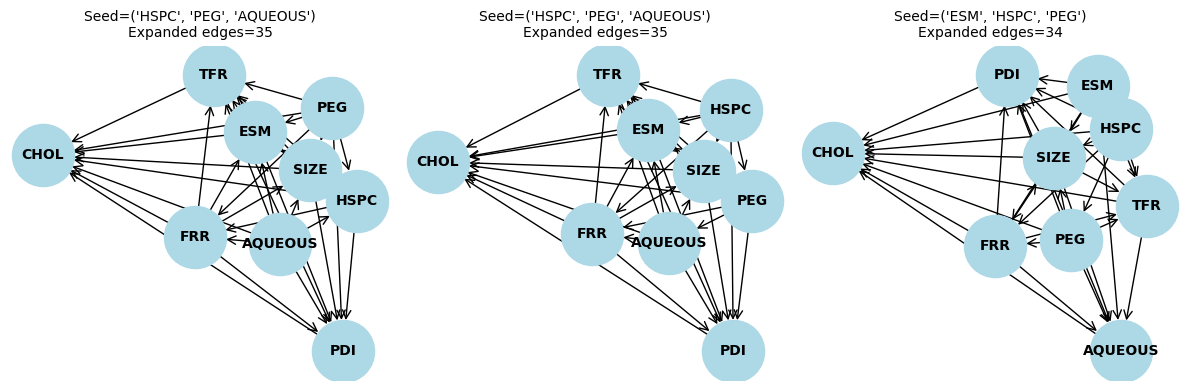

In [22]:
plot_expanded_dags(expanded_results, top_n=3)

#### Controlled expansion

In [23]:
def expand_dag_by_size(data, dag_edges, variables, alpha=0.05, max_nodes=6):
    """
    Expand a seed DAG step-by-step until reaching max_nodes.
    Uses CI tests to orient plausible edges, but always grows.

    Args:
      - data (pd.DataFrame): dataset (discretized).
      - dag_edges (list of tuples): seed DAG edges [(u, v), ...].
      - variables (list of str): all variables to consider.
      - alpha (float): significance level for CI tests.
      - max_nodes (int): maximum nodes to include.

    Returns:
      - list of tuples: expanded DAG edges.
    """
    dag = list(dag_edges)
    nodes = set(itertools.chain(*dag_edges))
    remaining = set(variables) - nodes
    while len(nodes) < max_nodes and remaining:
        # just take one new variable
        new_var = remaining.pop()
        added = False
        # connect it to one of the existing nodes
        for node in list(nodes):
            if not is_independent(new_var, node, [], data, alpha):
                # Try node -> new_var
                candidate = dag + [(node, new_var)]
                if nx.is_directed_acyclic_graph(nx.DiGraph(candidate)):
                    dag.append((node, new_var))
                    added = True
                    break
                # Try new_var -> node
                candidate = dag + [(new_var, node)]
                if nx.is_directed_acyclic_graph(nx.DiGraph(candidate)):
                    dag.append((new_var, node))
                    added = True
                    break
        # Even if no dependent relation is found, include node (isolated)
        nodes.add(new_var)
    return dag


In [24]:
expanded_results = []
for idx, row in res_df.head(3).iterrows():
    expanded = expand_dag_by_size(
        disc_df, row['dag'], list(disc_df.columns),
        alpha=0.05, max_nodes=6
    )
    expanded_results.append({
        "seed_nodes": row['nodes'],
        "seed_edges": row['dag'],
        "expanded_edges": expanded
    })
    print(f"\nExpanded DAG {idx+1}:")
    print(expanded)



Expanded DAG 1:
[('PEG', 'HSPC'), ('AQUEOUS', 'HSPC'), ('AQUEOUS', 'FRR'), ('FRR', 'ESM'), ('FRR', 'SIZE')]

Expanded DAG 2:
[('HSPC', 'PEG'), ('PEG', 'AQUEOUS'), ('AQUEOUS', 'FRR'), ('FRR', 'ESM'), ('FRR', 'SIZE')]

Expanded DAG 3:
[('ESM', 'HSPC'), ('HSPC', 'PEG'), ('HSPC', 'FRR'), ('FRR', 'SIZE'), ('FRR', 'TFR')]


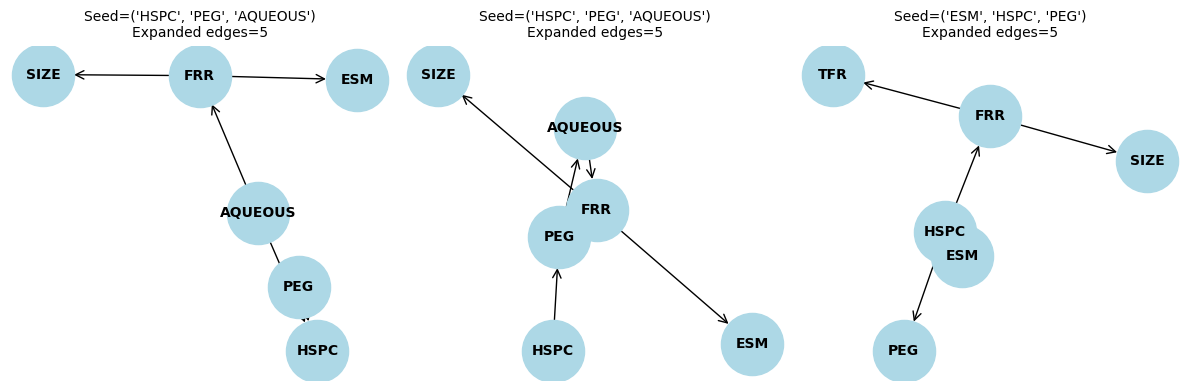

In [25]:
plot_expanded_dags(expanded_results, top_n=3)

### Merging maximizing global consistency

In [26]:
from collections import defaultdict

In [27]:
def merge_dags(seed_dags, variables):
    """
    Merge multiple seed DAGs into one global DAG by maximizing edge agreement.

    Args:
      - seed_dags (list of list of tuples): Each seed DAG is [(u,v), ...].
      - variables (list of str): All variables.

    Returns:
      - list of tuples: merged DAG edges.
    """
    # Count edge orientations
    votes = defaultdict(int)
    for dag in seed_dags:
        for u, v in dag:
            votes[(u, v)] += 1
            # penalize opposite orientation
            votes[(v, u)] -= 1
    # Sort edges by strength of preference
    ranked_edges = sorted(votes.items(), key=lambda x: abs(x[1]), reverse=True)
    # Build global DAG greedily
    global_dag = nx.DiGraph()
    global_dag.add_nodes_from(variables)
    for (u, v), score in ranked_edges:
        if score <= 0:
            continue
        global_dag.add_edge(u, v)
        if not nx.is_directed_acyclic_graph(global_dag):
            global_dag.remove_edge(u, v)
    return list(global_dag.edges())

In [28]:
def plot_dag_from_edges(edges, title="", ax=None):
    """
    Plot a DAG given its edges.
    """
    G = nx.DiGraph()
    G.add_edges_from(edges)
    pos = nx.spring_layout(G, seed=42)

    nx.draw(
        G, pos, with_labels=True, arrows=True,
        node_color="lightblue", node_size=2000,
        font_size=10, font_weight="bold",
        arrowstyle="->", arrowsize=15, ax=ax
    )
    ax.set_title(title, fontsize=10)


def plot_merged_dags(merged_results, top_n=6):
    """
    Plot multiple merged DAGs in a grid.

    Args:
      - merged_results (list of dict): each with {"edges": [(u,v),...], "label": str}
      - top_n (int): number of DAGs to plot
    """
    n = min(top_n, len(merged_results))
    ncols = 3
    nrows = math.ceil(n / ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 4*nrows))
    axes = axes.flatten()
    for i in range(n):
        row = merged_results[i]
        title = row.get("label", f"Merged {i+1}")
        plot_dag_from_edges(row["edges"], title, ax=axes[i])
    for j in range(n, len(axes)):
        fig.delaxes(axes[j])
    plt.tight_layout()
    plt.show()

In [29]:
top_seeds = [row['dag'] for _, row in res_df.head(3).iterrows()]
all_vars = list(disc_df.columns)
merged_edges = merge_dags(top_seeds, all_vars)

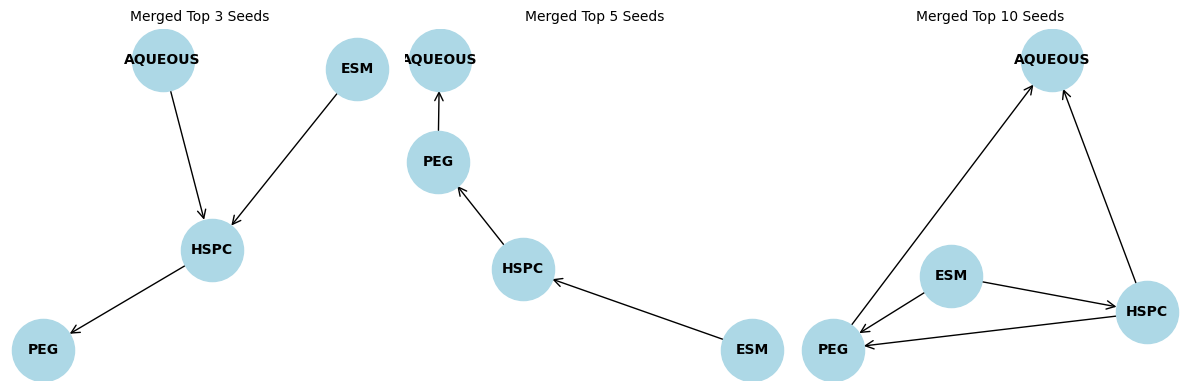

In [30]:
merged_results = []
for k in [3, 5, 10]:
    seeds = [row['dag'] for _, row in res_df.head(k).iterrows()]
    merged_edges = merge_dags(seeds, all_vars)
    merged_results.append({"edges": merged_edges, "label": f"Merged Top {k} Seeds"})

plot_merged_dags(merged_results, top_n=3)

### No merging (triplets as diagnostic tool)

In [31]:
import itertools

In [32]:
def discretize_dataframe(df, max_unique=10, bins=5):
    """
    Discretize high-cardinality columns into equal-frequency bins.

    Args:
      - df: pd.DataFrame
      - max_unique: max allowed unique values before binning
      - bins: number of quantile bins for discretization

    Returns:
      - discretized DataFrame
    """
    df_disc = df.copy()
    for col in df.columns:
        if df[col].nunique() > max_unique:
            try:
                df_disc[col] = pd.qcut(df[col], q=bins, duplicates="drop").astype(str)
            except Exception as e:
                print(f"Could not discretize {col}: {e}")
    return df_disc


def get_cpt(data, child, parents, alpha=1.0):
    child_states = data[child].unique()
    cpt = {}
    if not parents:
        counts = data[child].value_counts()
        total = counts.sum()
        for val in child_states:
            cpt.setdefault(None, {})[val] = (counts.get(val, 0) + alpha) / (total + alpha * len(child_states))
        return cpt
    counts = data.groupby(parents + [child]).size().reset_index(name="count")
    parent_counts = data.groupby(parents).size().reset_index(name="total")
    merged = pd.merge(counts, parent_counts, on=parents)
    for _, row in merged.iterrows():
        key = tuple(row[p] for p in parents)
        if key not in cpt:
            cpt[key] = {}
        cpt[key][row[child]] = (row["count"] + alpha) / (row["total"] + alpha * len(child_states))
    # fill missing child states
    for _, row in parent_counts.iterrows():
        key = tuple(row[p] for p in parents)
        if key not in cpt:
            cpt[key] = {}
        total = row["total"]
        for val in child_states:
            if val not in cpt[key]:
                cpt[key][val] = alpha / (total + alpha * len(child_states))

    return cpt


def log_likelihood(data, dag, alpha=1.0):
    variables = list(data.columns)
    cpts = {}
    for node in variables:
        parents = [u for (u, v) in dag if v == node]
        cpts[node] = get_cpt(data, node, parents, alpha=alpha)
    ll = 0.0
    for _, row in data.iterrows():
        for node in variables:
            parents = [u for (u, v) in dag if v == node]
            if not parents:
                prob = cpts[node][None].get(row[node], 1e-12)
            else:
                key = tuple(row[p] for p in parents)
                prob = cpts[node].get(key, {}).get(row[node], 1e-12)
            ll += log(prob)
    return ll


def num_params(data, dag):
    variables = list(data.columns)
    params = 0
    for node in variables:
        parents = [u for (u, v) in dag if v == node]
        states_child = data[node].nunique()
        if not parents:
            params += states_child - 1
        else:
            parent_states = np.prod([data[p].nunique() for p in parents])
            params += parent_states * (states_child - 1)
    return params


def score_dag(data, dag, alpha=1.0):
    ll = log_likelihood(data, dag, alpha=alpha)
    k = num_params(data, dag)
    n = len(data)
    aic = 2 * k - 2 * ll
    bic = log(n) * k - 2 * ll
    return ll, aic, bic


def hill_climb_search(data, score_metric="BIC", max_iter=1000, start_dag=None, candidate_edges=None, alpha=1.0):
    variables = list(data.columns)
    dag = start_dag if start_dag else []
    ll, aic, bic = score_dag(data, dag, alpha=alpha)
    score = {"LL": ll, "AIC": aic, "BIC": bic}[score_metric]
    steps = 0
    improved = True
    while improved and steps < max_iter:
        improved = False
        best_move = None
        best_score = score
        candidates = candidate_edges if candidate_edges is not None else itertools.permutations(variables, 2)
        for u, v in candidates:
            if u == v:
                continue
            # Try adding
            if (u, v) not in dag:
                new_dag = dag + [(u, v)]
                if nx.is_directed_acyclic_graph(nx.DiGraph(new_dag)):
                    ll_new, aic_new, bic_new = score_dag(data, new_dag, alpha=alpha)
                    new_score = {"LL": ll_new, "AIC": aic_new, "BIC": bic_new}[score_metric]
                    if (score_metric == "LL" and new_score > best_score) or \
                       (score_metric in ["AIC", "BIC"] and new_score < best_score):
                        best_move = ("add", (u, v))
                        best_score = new_score
            # Try removing
            if (u, v) in dag:
                new_dag = [e for e in dag if e != (u, v)]
                if nx.is_directed_acyclic_graph(nx.DiGraph(new_dag)):
                    ll_new, aic_new, bic_new = score_dag(data, new_dag, alpha=alpha)
                    new_score = {"LL": ll_new, "AIC": aic_new, "BIC": bic_new}[score_metric]
                    if (score_metric == "LL" and new_score > best_score) or \
                       (score_metric in ["AIC", "BIC"] and new_score < best_score):
                        best_move = ("remove", (u, v))
                        best_score = new_score
        if best_move:
            action, edge = best_move
            if action == "add":
                dag.append(edge)
            elif action == "remove":
                dag.remove(edge)
            score = best_score
            improved = True
            steps += 1
    return dag, score

In [33]:
def plot_dag_from_edges(edges, title="Learned DAG", ax=None):
    G = nx.DiGraph()
    G.add_edges_from(edges)
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 5))
    pos = nx.spring_layout(G, seed=42)
    nx.draw_networkx_nodes(G, pos, ax=ax, node_size=1200, node_color="lightblue")
    nx.draw_networkx_edges(G, pos, ax=ax, arrows=True, arrowstyle="-|>", arrowsize=15)
    nx.draw_networkx_labels(G, pos, ax=ax, font_size=10, font_weight="bold")
    ax.set_title(title)
    ax.axis("off")
    return ax

In [34]:
disc_df_binned = discretize_dataframe(disc_df, max_unique=10, bins=5)
seed_dag = res_df.iloc[0]["dag"]
global_dag, global_score = hill_climb_search(
    disc_df_binned, score_metric="AIC", start_dag=seed_dag, alpha=1.0
)
print("Global DAG edges:", global_dag)
print("Best AIC score:", global_score)

Global DAG edges: [('PEG', 'HSPC'), ('AQUEOUS', 'HSPC'), ('ESM', 'SIZE'), ('CHOL', 'PDI'), ('HSPC', 'PDI'), ('PEG', 'FRR'), ('AQUEOUS', 'SIZE'), ('HSPC', 'ESM'), ('AQUEOUS', 'TFR'), ('PEG', 'TFR'), ('AQUEOUS', 'FRR'), ('SIZE', 'PDI'), ('CHOL', 'ESM'), ('AQUEOUS', 'PEG'), ('CHOL', 'PEG'), ('FRR', 'SIZE'), ('SIZE', 'TFR'), ('CHOL', 'FRR'), ('AQUEOUS', 'CHOL')]
Best AIC score: 3590.9246196727413


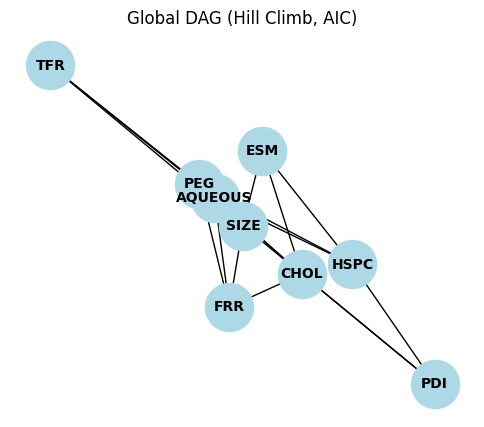

In [38]:
plot_dag_from_edges(global_dag, title="Global DAG (Hill Climb, AIC)")
plt.show()